In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
users = np.loadtxt('../processed_data/delicious/userID_k_3.txt')
data = np.loadtxt('../processed_data/delicious/bookmarkID_K_3.txt')
output_score_file = "../ndcg_scores/cascade_ucb1/score_dlc_u_3.txt"
users = np.ones(users.size)
ones = 3 # change for each file depending upon no. of ones.
timesteps = users.size
#timesteps = 5
no_recommendation = data.shape[1]
times_appeared = {}
weight = {}
scores = np.zeros(timesteps)
best_dcg = 0
for i in range(0,ones):
    best_dcg += 1.0/np.log2(i+2)

In [3]:
def receive_user(t):
    return users[t]

def receive_items(t):
    return data[t]


In [4]:
def cascade_ucb1(u,items,t):
    if not u in times_appeared:
        times_appeared[u] = {}
        weight[u] = {}
    for i in range(0,items.size):
        if not items[i] in times_appeared[u]:
            times_appeared[u][items[i]] = 1.0
            weight[u][items[i]] = np.random.uniform(low=0.01,high=0.1,size=1)
               
    ucb = np.zeros(items.size)
    for i in range(0,items.size):
        ucb[i] = weight[u][items[i]] + np.sqrt((1.5*np.log2(t+1))/times_appeared[u][items[i]])
    
    sorted_indices = np.argsort(ucb)
    sorted_indices = sorted_indices[::-1]
    sorted_items = np.zeros(items.size)
    for i in range(0,items.size):
            sorted_items[i] = items[sorted_indices[i]]
    return sorted_items

In [5]:
def score(t,clicked):
    for i in range(0,clicked.size):
        scores[t] += clicked[i]/np.log2(i+2)
    scores[t] /= best_dcg

In [6]:
def simulate_click(u,items,ranked_items):
    
    clicked = np.zeros(items.size)
    feedback = 999999
    for i in range(0,items.size):
        for j in range(0,ones):
            if items[j] == ranked_items[i]:
                clicked[i] = 1
                if i < feedback:
                    feedback = i
    
    return feedback,clicked

In [7]:
def update(u,feedback,ranked_items,clicked):
    for i in range(0,feedback+1):
        weight[u][ranked_items[i]] = (times_appeared[u][ranked_items[i]]*weight[u][ranked_items[i]]+clicked[i])/(times_appeared[u][ranked_items[i]]+1.0)
        times_appeared[u][ranked_items[i]] += 1.0

In [8]:
start_time = time.time()
for t in range(0,timesteps):
    
    u = receive_user(t)
    items = receive_items(t)
    ranked_items = cascade_ucb1(u,items,t)
    feedback,clicked = simulate_click(u,items,ranked_items)
    score(t,clicked)
    #print feedback
    #print clicked
    update(u,feedback,ranked_items,clicked)
end_time = time.time()

In [9]:
for t in range(1,timesteps):
    scores[t] += scores[t-1]

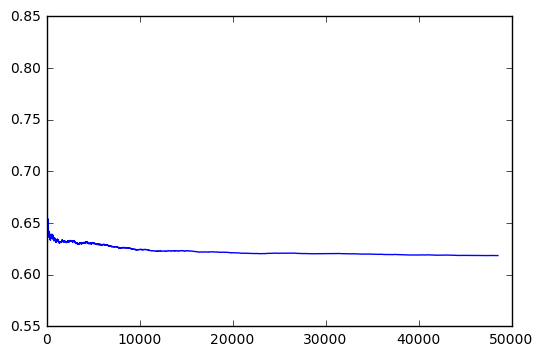

In [10]:
avg = np.zeros(timesteps)
for t in range(0,timesteps):
    avg[t] = scores[t]/(t+1)
plt.plot(avg)
plt.show()

In [11]:
print "Time taken by the algorithm to run is %lf seconds" %(end_time-start_time)
np.savetxt(output_score_file,avg,fmt="%.3f",delimiter=' ')

Time taken by the algorithm to run is 7.759719 seconds
